Traduction: Only for Genius?
What is the right answer?


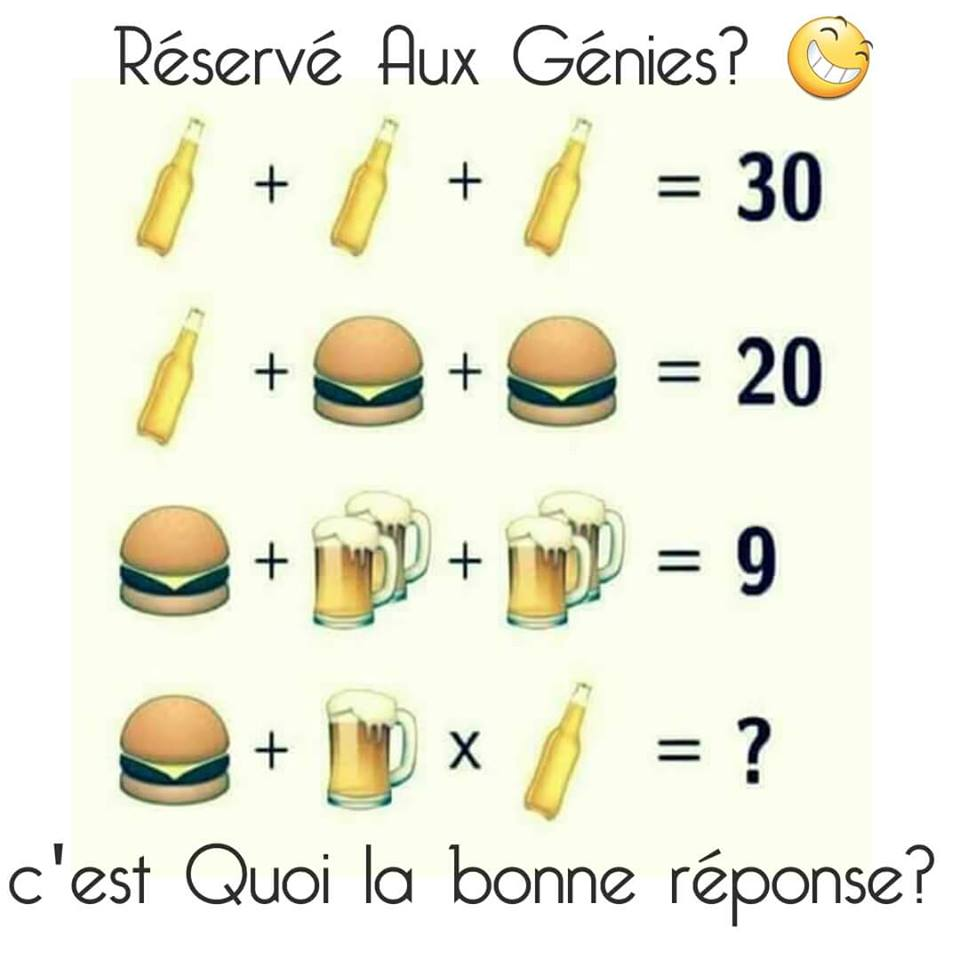

In [104]:
%matplotlib inline

import pandas as pd
from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')
import re
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", context="talk")
import numpy as np



# usefull function
def return_last_findall(x):
    if len(x):
        return x[-1]
    else:   
        return 'null'


# Post: https://www.facebook.com/476834269088771/photos/a.476856779086520.1073741827.476834269088771/1053299568108902/?type=3&theater

fig = Image(filename=('./figs/genius.jpg'))
print 'Traduction: Only for Genius?'
print 'What is the right answer?'
fig

In [105]:
# Read Data
df = pd.DataFrame.from_csv('data/comments_swag_post_1053299568108902.csv')
df.dropna(subset=['comment_message','comment_author'],inplace=True) # remove empty comments
print '# of comments: ' + str(len(df))

df_unique_author = df.comment_author.unique()
print '# of unique authors: ' + str(len(df_unique_author))

# of comments: 20850
# of unique authors: 13950


In [106]:
# Little bit of regex to extract the last numbers of a comments
response = df.comment_message.str.findall('[0-9]+')
response = map(return_last_findall, list(response))
df['response'] = response
# Found out that most of the response='10' are explaining the reasoning
# in this case the first numbers is the answer
mask_10 = (df.response=='10')
response_10 = df[mask_10].comment_message.str.extract('([0-9]+)')
df.loc[mask_10,'response'] = response_10

# Let's see the answers: 'null' is attributed to comments without digits
most_frequent_answer = df.groupby('response').count()['comment_message'].sort_values(ascending=False)
print most_frequent_answer.head(10)

response
15      6436
60      3203
null    2639
70      2156
17      1924
16      1512
25      1435
1        222
5        192
2        173
Name: comment_message, dtype: int64


In [107]:
# Let's extract the first name of comment authors
df['first_name'] = df.comment_author.str.split(' ')
df['first_name'] = df.first_name.apply(lambda x: x[0])

most_frequent_first_name = df.groupby('first_name').count()['comment_message'].sort_values(ascending=False)
print most_frequent_first_name.head(10)

first_name
Julie        2124
Badav         308
Jean          215
Marie         205
Patrick       143
Michel        142
Martine       126
Dominique     117
Philippe      113
Sylvie        112
Name: comment_message, dtype: int64


In [108]:
# Remove comment that answer another comment
# Those are mostly explanation
df = df[pd.isnull(df.parent_id)]

# Let also filter the answers that are plausible (that i was able to understand)
keep_answers = ['25','16','17','70','60','15']
length_total = len(df)
df_pl = df[df.response.isin(keep_answers)]
length_plausible = len(df_pl)

print '% of plausible answers: ' + str(float(length_plausible)/length_total*100.0) + '%'

% of plausible answers: 88.6366725567


In [109]:
# Let's see the new results
most_frequent_answer_pl = df_pl.groupby('response').count()['comment_message'].sort_values(ascending=False)
most_frequent_first_name_pl = df_pl.groupby('first_name').count()['comment_message'].sort_values(ascending=False)

print most_frequent_answer_pl.head(10)
print most_frequent_first_name_pl.head(10)

# Damn that Julie and Badav was really into correcting people

response
15    3549
60    2917
70    2048
17    1858
16    1438
25    1232
Name: comment_message, dtype: int64
first_name
Jean         176
Marie        154
Patrick      101
Michel        99
Dominique     94
Alain         93
Martine       93
Sylvie        89
Christine     85
Philippe      85
Name: comment_message, dtype: int64


In [114]:
# Let's remove the duplicate authors

df_drop =  df_pl.drop_duplicates(subset=['comment_author'])

# Let's see whose right or wrong !
df_drop_wrong = df_drop[df_drop.response!='15']
df_drop_right = df_drop[df_drop.response=='15']

first_name_wrong = df_drop_wrong.groupby('first_name').count()['comment_published'].sort_values()
first_name_right = df_drop_right.groupby('first_name').count()['comment_published'].sort_values()
first_name_total = df_drop.groupby('first_name').count()['comment_published'].sort_values()

df_first = pd.concat([first_name_wrong, first_name_right, first_name_total],axis=1, join='inner')
df_first.columns = ['wrong','right','total']

# Ratio of wrong/right per name
df_first['wrong_ratio'] = df_first.wrong/df_first.total*100
df_first['right_ratio'] = df_first.right/df_first.total*100

# Woww what name gave you the highest 'stupid' prior:
most_frequent_first_wrong = df_first.sort_values('wrong_ratio', ascending=False)

# What is the ratio of good answer?
ratio_right = float(len(df_drop_right))/len(df_drop)*100
print 'Ratio of right answer: ' + str(ratio_right) + '%'

Ratio of right answer: 27.7056277056%


In [99]:
print 'Most frequent first name for wrong answers\n'
print most_frequent_first_wrong.head(10)
print '\n'*2
print '-'*75
print '\n'*2
print 'Most frequent first name for wrong answers (with at least 30 appearance of the first name)\n'
print most_frequent_first_wrong[most_frequent_first_wrong.total>=30].head(10)

Most frequent first name for wrong answers

            wrong  right  total  wrong_ratio  right_ratio
first_name                                               
André          19      1     20    95.000000     5.000000
Michèle        17      1     18    94.444444     5.555556
Bernadette     16      1     17    94.117647     5.882353
Xavier         15      1     16    93.750000     6.250000
Ghislaine      15      1     16    93.750000     6.250000
Yolande        14      1     15    93.333333     6.666667
Raymond        14      1     15    93.333333     6.666667
Georges        14      1     15    93.333333     6.666667
Ginette        13      1     14    92.857143     7.142857
Rene           11      1     12    91.666667     8.333333



---------------------------------------------------------------------------



Most frequent first name for wrong answers (with at least 30 appearance of the first name)

            wrong  right  total  wrong_ratio  right_ratio
first_name                  

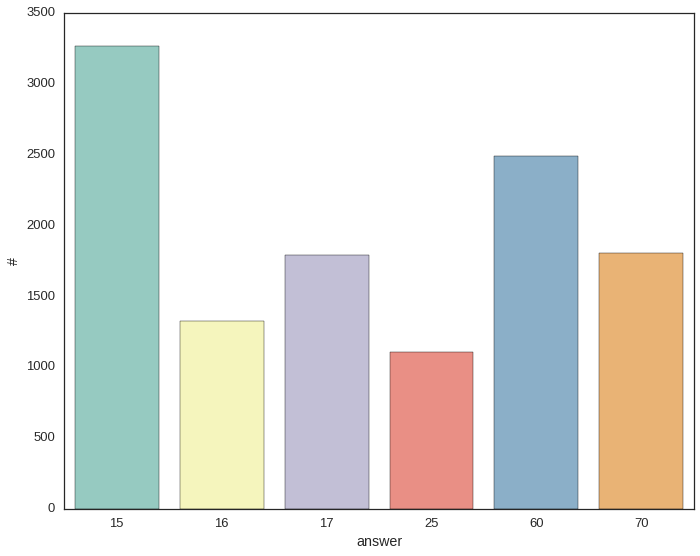

In [116]:
# Let's plot the distribution of the answers:
response_plt = df_drop.groupby('response').count()['comment_message'].sort_values(ascending=False)

f, ax = plt.subplots(1, 1, figsize=(10, 8), sharex=True)
x = np.array(list(response_plt.index))
sns.barplot(x, response_plt.values, palette="Set3", ax=ax)
ax.set_ylabel('#')
ax.set_xlabel('answer')
plt.tight_layout(h_pad=3)
#plt.show()
plt.savefig('./figs/facebook_swag.png')#, bbox_inches='tight')

In [ ]:
# To explain the wrong answer let's expose some comments:
# For the '60':
#     - '10+10+10=30  10+5+5=20.  5+2+2=9. 5+1x10=60' 
#              + '10+10+10=30  10+5+5=20.  5+2+2=9. 5+1x10=60'
#     - 'Il y a aucun parentheses pour faire l application 5+1=6 × 10 = 60'
#              + 'there is no brackets to do the application 5+1=6 × 10 = 60'
#     - 'Cousine ça fait 60 (5+1=6 )et après c'est multiplié si tu regardes bien 6 × 10 =60 .Bisous'
#              + 'Girl, the result is 60 (5+1=6) then it is multiplied if you look closely 6x10=60. Kisses'
#     - 'Bouteille vaut 10, hamburger vaut 5 et chope vaut 1 donc 5+1 que multiplie 10 = 60  Y'a plus bête, 
#        mais il ne faut pas être un génie !!!'
#              + 'Bottle is 10, hamburger is 5 and the beer is 1 so 5+1 that I multiply by 10 = 60. This 
#        should be idiot proof, but you don't need to be a genius !!!' HUUUUUHHHHHHHHH!!!

# For the '70' (there forget to see the two beers):
#     - 'une canette=10     un sandwich=5             une chope de biere=2           donc 5+2x10 se qui fait  7x10=70'
#              + 'one Bottle=10  one sandwich=5    one beer=2   so 5+2x10 gives 7x10=70'
#     - '70 !!! J'explique . ..(10+10+10=30) (10+5+5=20) (5+2+2=9) (5+2x10=70)'
#              + '70 !!! I explain . .. (10+10+10=30) (10+5+5=20) (5+2+2=9) (5+2x10=70)'
#     - '70 voyons'
#              + '70 come on'

# For the '25' (they no the basic of math but are not really focused):
#     - 'maman va falloir retourner à l'école : 5+2*10=25'
#              + 'mum you'll need to go back to school: 5+2*10=25'
#     - 'Force pas, tu as tord. Une bouteille = 10 / Un hamburger = 5 / Une bière = 2  Donc 5+10x2 = 25'
#              + 'Stop, you are wrong. One bottle = 10 / One hamburger = 5 / One beer = 2 So 5+10x2 = 25'

# For the '16' (they don't recognize the multiplication):
#     - '5+1+10=16'
#              + '5+1+10=16'
#     - '16 je n avais pas vu mais il y a une seule bière'
#              + '16 I didn't see that there is only one beer'

# For the '17' (...):
#     - 'ah bon je comprends pas c'est 5+2+10=17?'
#              + 'well i don't understand, is it 5+2+10=17?'


# Let's see some weird answers:
#     - 'En comptan 5 plus 7 Foix 10 et égale a 120 très nul en math'
#     - 'ah oui j'avais pas vu le multiplié, donc ça fait 160 euros ,  oupsssssssssssssss'
#     - 'Sauf que dans ta parenthèse ça fait 11 1+10 loooool donc ton résultat est faux. Loooool'
#     - '10 +10 + 10 = 30 donc 10 + 5 + 5 = 20 donc 5 + 2 + 2 = 9 donc 5 + 1 + 10 = 11' OKAY!?!?
#     - 'Vous NE savez pas compter c'est egal a 12'
#     - '14 (bouteille 10, hamburger 5 et bière 4) 5 plus 2 car il n'y a qu'un verre fois 10 égale 14'